In [ ]:
# simulation 
0. calculate global tracement as : price drop today as of the highest price in the history
1. invest spy 100 at day 1. 
2. spy global tracement to be 10%， then sell another 20% spy, use them to buy tqqq
3. samilarly, if global tracement to be 20%, sell 50% spy, use them to buy tqqq
4. samilarly, if global tracement to be 30%, sell 80% spy, use them to buy tqqq
5. anytime if global tracement go back to 0%, sell all tqqq, and buy spy again.
6. simulate the final price

In [157]:

#df['dt'] = df.index.dt

[*********************100%***********************]  2 of 2 completed


In [158]:
df.index#.apply(lambda x: x.dt)

DatetimeIndex(['2024-01-02 00:00:00+00:00', '2024-01-03 00:00:00+00:00',
               '2024-01-04 00:00:00+00:00', '2024-01-05 00:00:00+00:00',
               '2024-01-08 00:00:00+00:00', '2024-01-09 00:00:00+00:00',
               '2024-01-10 00:00:00+00:00', '2024-01-11 00:00:00+00:00',
               '2024-01-12 00:00:00+00:00', '2024-01-16 00:00:00+00:00',
               ...
               '2024-10-28 00:00:00+00:00', '2024-10-29 00:00:00+00:00',
               '2024-10-30 00:00:00+00:00', '2024-10-31 00:00:00+00:00',
               '2024-11-01 00:00:00+00:00', '2024-11-04 00:00:00+00:00',
               '2024-11-05 00:00:00+00:00', '2024-11-06 00:00:00+00:00',
               '2024-11-07 00:00:00+00:00', '2024-11-08 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=217, freq=None)

In [470]:
calculate_maximum_rolling_tracment([1,2,3,0,4,10])

np.float64(100.0)

In [555]:
import pandas as pd
def calculate_maximum_tracment(price_series):
    # Ensure the series is in pandas Series format
    if isinstance(price_series, list):
        price_series = pd.Series(price_series)
    
    # Initialize variables to track the rolling maximum price and maximum retracement
    rolling_max = price_series.cummax()  # Cumulative max tracks the highest price up to each point
    retracements = (rolling_max - price_series) / rolling_max * 100  # Retracement at each point
    
    # The maximum retracement is the maximum value in the retracements series
    max_retracement = retracements.max()
    
    return max_retracement
    
def simulate_trading(start_dt,end_dt, initial_investment, thresholds=[10, 20, 30],sell_amount = [0.15,0.5,1,1]):
    # Ensure the 'dt' column is the index
    df = yf.download(['spy','tqqq'], start=start_dt,end = end_dt)
    df = df['Adj Close'].copy()
    df['spy'] = df['SPY']
    df['tqqq'] = df['TQQQ']
    df = df[['spy' , 'tqqq']].copy()
    df['spy_max'] = df['spy'].cummax()  # Track the highest SPY price up to each day
    df['spy_retracement'] = (df['spy_max'] - df['spy']) / df['spy_max'] * 100  # Calculate retracement for SPY
        
        # Calculate the global retracement for TQQQ
    df['tqqq_max'] = df['tqqq'].cummax()  # Track the highest TQQQ price up to each day
    df['tqqq_retracement'] = (df['tqqq_max'] - df['tqqq']) / df['tqqq_max'] * 100
    #df.set_index('dt', inplace=True)
    
    # Initialize variables
    
    tqqq_position = 0  # No position in TQQQ initially
    highest_spy_price = df['spy'].iloc[0]  # Highest SPY price seen so far (initially the first day's price)

    spy_position = initial_investment/(df['spy'].iloc[0])  # Start with all money in SPY
    
    events = []  # List to store all buy/sell events
    history = []  # History of the portfolio for tracking
    notes = {}  # Dictionary to store combined notes for each day

    # Track last retracement trigger
    last_trigger = {'low': False, 'median': False, 'high': False}
    
    # Iterate over the rows, now using 'dt' as the index
    for date, row in df.iterrows():
        
        spy_price = row['spy']
        tqqq_price = row['tqqq']
        
        # Calculate global retracement
        retracement = row['spy_retracement']#(highest_spy_price - spy_price) / highest_spy_price * 100 if highest_spy_price > spy_price else 0
        retracement_tqqq = row['tqqq_retracement']#
        
        # Update the highest SPY price seen so far
        highest_spy_price = max(highest_spy_price, spy_price)

        # Initialize holding values
        spy_holding_value = spy_position * spy_price
        tqqq_holding_value = tqqq_position * tqqq_price
        total_value = spy_holding_value + tqqq_holding_value
        
        # Track events for the day
        daily_events = []
        event_reason = ''
        # Adjust investment based on retracement thresholds
        if retracement >= thresholds[2] and not last_trigger['high'] and spy_position > 0:
            # Sell 80% of SPY and buy TQQQ
            spy_to_sell = spy_position * sell_amount[2] #0.80
            tqqq_position += (spy_to_sell * spy_price) / tqqq_price
            spy_position -= spy_to_sell
            event_reason += f"high spy drop; Sell 80% SPY ({spy_to_sell * spy_price})"
            
            last_trigger['high'] = True  # Mark the 30% retracement as triggered

        elif retracement >= thresholds[1] and not last_trigger['median'] and spy_position > 0:
            # Sell 50% of SPY and buy TQQQ
            spy_to_sell = spy_position * sell_amount[1]
            tqqq_position += (spy_to_sell * spy_price) / tqqq_price
            spy_position -= spy_to_sell
            event_reason = f"median spy drop; Sell 50% SPY ({spy_to_sell * spy_price})"
            
            
            last_trigger['median'] = True  # Mark the 20% retracement as triggered

        elif retracement >= thresholds[0] and not last_trigger['low'] and spy_position > 0:
            # Sell 20% of SPY and buy TQQQ
            spy_to_sell = spy_position * sell_amount[0]
            tqqq_position += (spy_to_sell * spy_price) / tqqq_price
            spy_position -= spy_to_sell
            event_reason += f"low spy drop; Sell 20% SPY ({spy_to_sell * spy_price})"
            last_trigger['low'] = True  # Mark the 10% retracement as triggered
        
        # If retracement goes back to 0%, sell all TQQQ and buy back SPY
        if retracement==0 and tqqq_position > 0 and (
            last_trigger['low'] or 
                                                       last_trigger['median'] or 
                                                       last_trigger['high'] ) :
            

            tqqq_to_sell = tqqq_position * sell_amount[3]
            tqqq_position -= tqqq_to_sell
            spy_position += (tqqq_to_sell * tqqq_price) / spy_price
            
            #spy_position += tqqq_position * tqqq_price / spy_price
            #tqqq_position = 0
            #event_reason += f"back to normal; sell all tqqq"
            
            
            # Reset all trigger flags when we return to 0% retracement
            last_trigger = {'low': False, 'median': False, 'high': False}

        
        # Save the current state to the history for tracking
        history.append({
            'dt': date,
            'last_trigger':last_trigger.copy(),
            'spy_price': spy_price,
            'tqqq_price': tqqq_price,
            'spy_position': spy_position,
            'tqqq_position': tqqq_position,
            'retracement': retracement,
            'retracement_tqqq': retracement_tqqq,
            
            'spy_holding_value': spy_holding_value,
            'tqqq_holding_value': tqqq_holding_value,
            'total_value': total_value,
            'if_event': True if len(event_reason)>0 else False ,
            'event_reason': event_reason, 
        })

        #print(date, last_trigger)
    # Final portfolio value: all in SPY (or TQQQ, depending on the last position)
    final_value = spy_position * df['spy'].iloc[-1] + tqqq_position * df['tqqq'].iloc[-1]
    roi_bench = final_value/initial_investment, df['spy'].iloc[-1]/df['spy'].iloc[0],df['tqqq'].iloc[-1]/df['tqqq'].iloc[0]
    roi_bench = final_value/initial_investment, df['spy'].iloc[-1]/df['spy'].iloc[0],df['tqqq'].iloc[-1]/df['tqqq'].iloc[0]
    
    
    # Convert events to a DataFrame
    events_df = pd.DataFrame(events, columns=['dt', 'reason', 'holding_value', 'total_value']).set_index('dt')

    # Add 'note' column to the original DataFrame
    df['note'] = df.index.map(notes)
    df1 = pd.DataFrame(history).set_index('dt')
    df1['%tqqq'] = df1['tqqq_holding_value']*1.000/df1['total_value']

    tracement_bench = [calculate_maximum_tracment(df1['total_value']), 
                       calculate_maximum_tracment(df1['spy_price']), 
                       calculate_maximum_tracment(df1['tqqq_price'])
                      ]
    print('roi',roi_bench)
    print('risk',tracement_bench)
    return df1, final_value, events_df, {'roi_new':roi_bench[0],
                                         'roi_spy':roi_bench[1],
                                         'roi_tqqq':roi_bench[2],
                                         'max_retrace_new': tracement_bench[0],
                                         'max_retrace_spy': tracement_bench[1],
                                         'max_retrace_tqqq': tracement_bench[2],
                                         'start_dt':start_dt,
                                         'end_dt':end_dt
                                         
                                        }
                                         

In [559]:
result = []
for dt_pair in [('2020-01-01','2021-01-01'),
                ('2021-01-01','2022-01-01'),
                ('2022-01-01','2023-01-01'),
                ('2023-01-01','2024-01-01'),
                ('2024-01-01','2024-11-08'),
               ]:
    start_dt, end_dt = dt_pair
    df1a, finala, events,bench_mark = simulate_trading(start_dt,end_dt, initial_investment=initial_investment, 
                                        thresholds=[3, 7, 20],
                                       sell_amount = [0,0.3,1,0.8])
    result.append(bench_mark)
result_by_year = pd.DataFrame(result)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed

roi (np.float64(2.2903411387051547), np.float64(1.1723527861396357), np.float64(2.0013212673892533))
risk [np.float64(48.081953140376754), np.float64(33.71726869437801), np.float64(69.92207645661374)]
roi (np.float64(1.305054417382265), np.float64(1.3050544173822651), np.float64(1.9134885147432195))
risk [np.float64(5.1141528591587475), np.float64(5.11415285915876), np.float64(30.433203260602426)]
roi (np.float64(0.49971017626718495), np.float64(0.8135360057884367), np.float64(0.2032348194209483))
risk [np.float64(58.23124238435135), np.float64(24.496380796744297), np.float64(81.01575445969542)]
roi (np.float64(1.483529411291408), np.float64(1.2670921990125532), np.float64(3.0492268479893596))
risk [np.float64(13.874186940204366), np.float64(9.974312305304823), np.float64(33.14182474703366)]
roi (np.float64(1.3566338704048524), np.float64(1.272033375241395), np.float64(1.733483077302654))
risk [np.float64(9.51751669190466), np.float64(8.4056171194596), np.float64(37.37195516559662)]


In [560]:
result_by_year

,roi_new,roi_spy,roi_tqqq,max_retrace_new,max_retrace_spy,max_retrace_tqqq,start_dt,end_dt
0,2.290341,1.172353,2.001321,48.081953,33.717269,69.922076,2020-01-01,2021-01-01
1,1.305054,1.305054,1.913489,5.114153,5.114153,30.433203,2021-01-01,2022-01-01
2,0.499710,0.813536,0.203235,58.231242,24.496381,81.015754,2022-01-01,2023-01-01
3,1.483529,1.267092,3.049227,13.874187,9.974312,33.141825,2023-01-01,2024-01-01
4,1.356634,1.272033,1.733483,9.517517,8.405617,37.371955,2024-01-01,2024-11-08


In [565]:
result_by_year[['roi_new','roi_spy','roi_tqqq']].product()

roi_new     3.006116
roi_spy     2.006183
roi_tqqq    4.113866
dtype: float64

In [557]:
pd.DataFrame([bench_mark])

,roi_new,roi_spy,roi_tqqq,max_retrace_new,max_retrace_spy,max_retrace_tqqq,start_dt,end_dt
0,0.49971,0.813536,0.203235,58.231242,24.496381,81.015754,2022-01-01,2023-01-01


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


roi (np.float64(2.00801221711849), np.float64(1.3040408155037602), np.float64(0.9992259510014639))
risk [np.float64(58.231239850658035), np.float64(24.496387449508017), np.float64(81.01575505706792)]
roi (np.float64(1.6791643034853363), np.float64(1.3040408155037602), np.float64(0.9992262271678745))
risk [np.float64(60.96624237325033), np.float64(24.496387449508017), np.float64(81.01574865861105)]


[*********************100%***********************]  2 of 2 completed

roi (np.float64(1.4442799692500647), np.float64(1.3040407287490117), np.float64(0.9992259510014639))
risk [np.float64(66.42733604296431), np.float64(24.49638581982135), np.float64(81.01575505706792)]


(np.float64(1679.1643034853364), np.float64(1444.2799692500648))

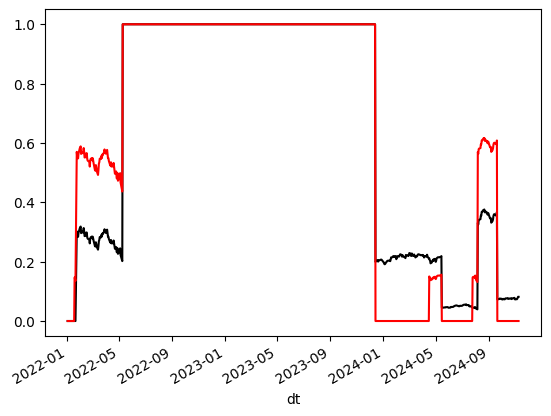

In [544]:
initial_investment = 1000

df1a, finala, events = simulate_trading('2022-01-01', initial_investment=initial_investment, 
                                        thresholds=[3, 7, 20],
                                       sell_amount = [0,0.3,1,0.8])

df1a, finala, events = simulate_trading('2022-01-01', initial_investment=initial_investment, 
                                        thresholds=[3, 7, 15],
                                       sell_amount = [0,0.3,1,0.8])
# 一旦超过15， 就有可能去20 所以等一下
# 10 又太多了， 经常8左右就可以反弹了

df1b, finalb, events = simulate_trading('2022-01-01', initial_investment=initial_investment, 
                                        thresholds=[3, 7, 15],
                                       sell_amount = [0.15,0.5,1,1])
df1a['%tqqq'].plot(color = 'k')
df1b['%tqqq'].plot(color = 'r')
finala,finalb

#pd.concat([df1b['total_value']).plot(

<Axes: xlabel='dt'>

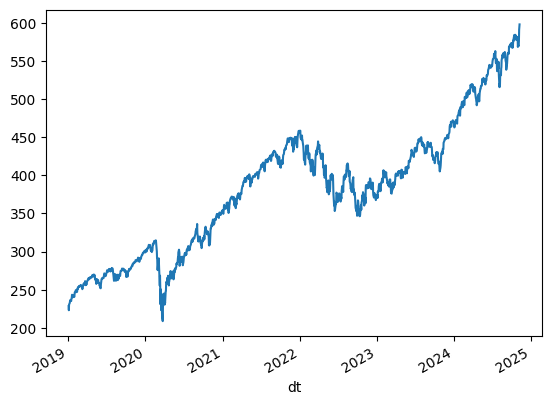

In [532]:
df1a['spy_price'].plot()

<Axes: xlabel='dt'>

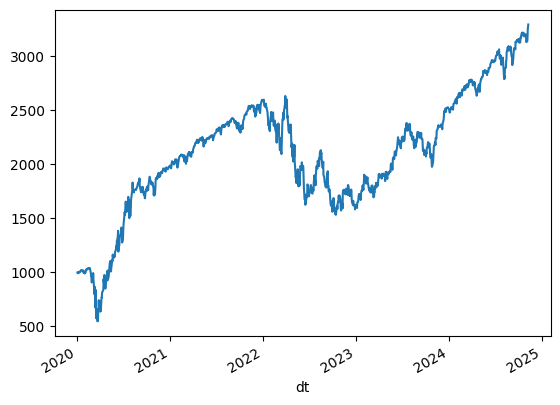

In [458]:
df1a['total_value'].plot()

[*********************100%***********************]  2 of 2 completed

(np.float64(3.2803214261669824), np.float64(1.9793944543401034), np.float64(3.764807809656967))
risk [np.float64(51.55673298817882), np.float64(33.71726057702386), np.float64(81.65984784727695)]


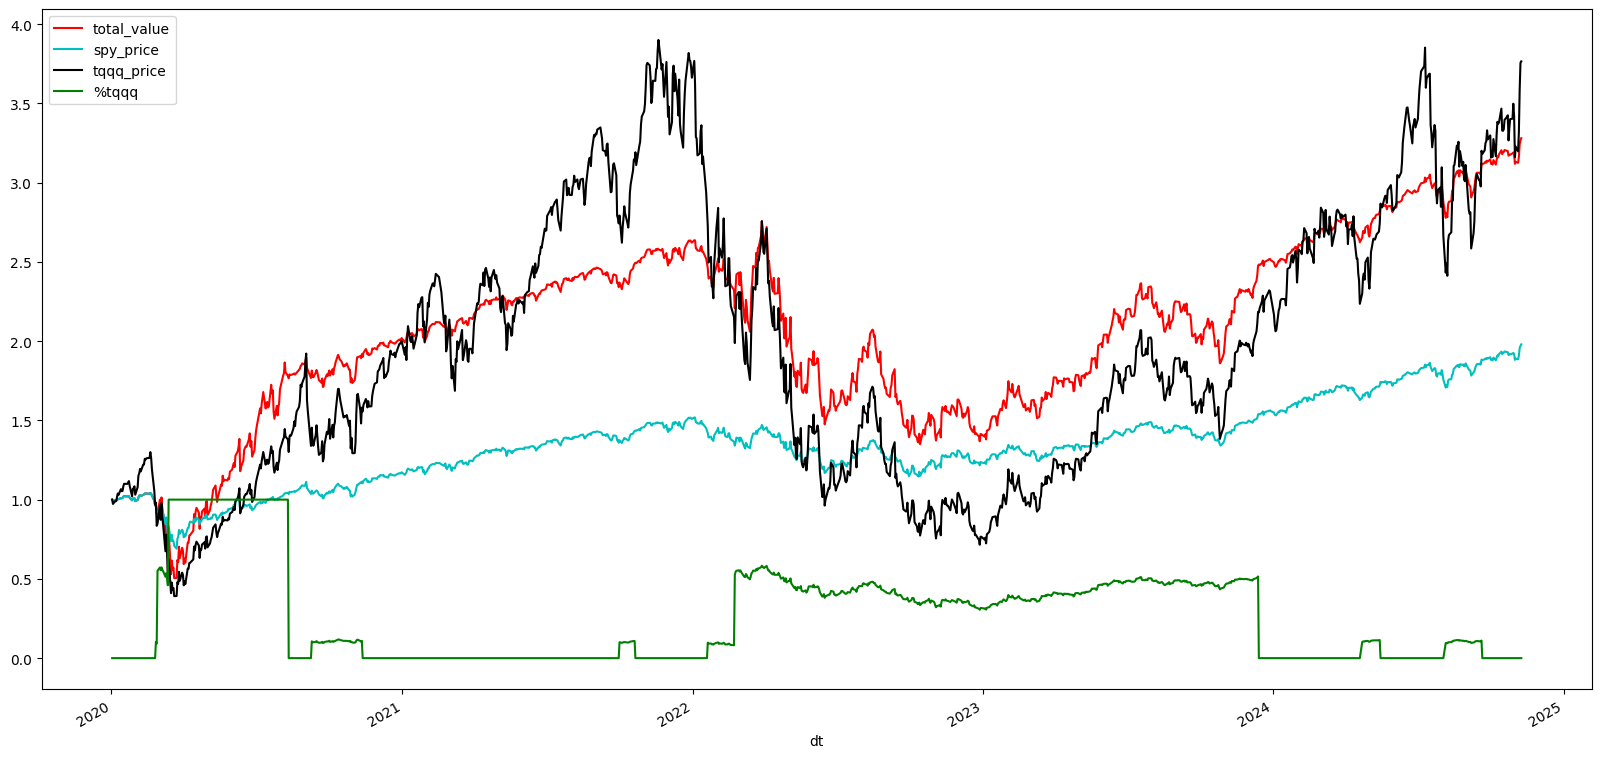

In [511]:
initial_investment = 1000
df1, final, events = simulate_trading('2020-01-01', initial_investment=initial_investment, thresholds=[5, 10, 25])



ax = (df1[['total_value']]/initial_investment).plot(figsize=(20,10),color = 'r')
(df1['spy_price']/(df1['spy_price'].iloc[0])).plot(ax = ax, color = 'c')
(df1['tqqq_price']/(df1['tqqq_price'].iloc[0])).plot(ax=ax, color = 'k')
df1['%tqqq'].plot(ax=ax, color ='green')
ax.legend()

[*********************100%***********************]  2 of 2 completed


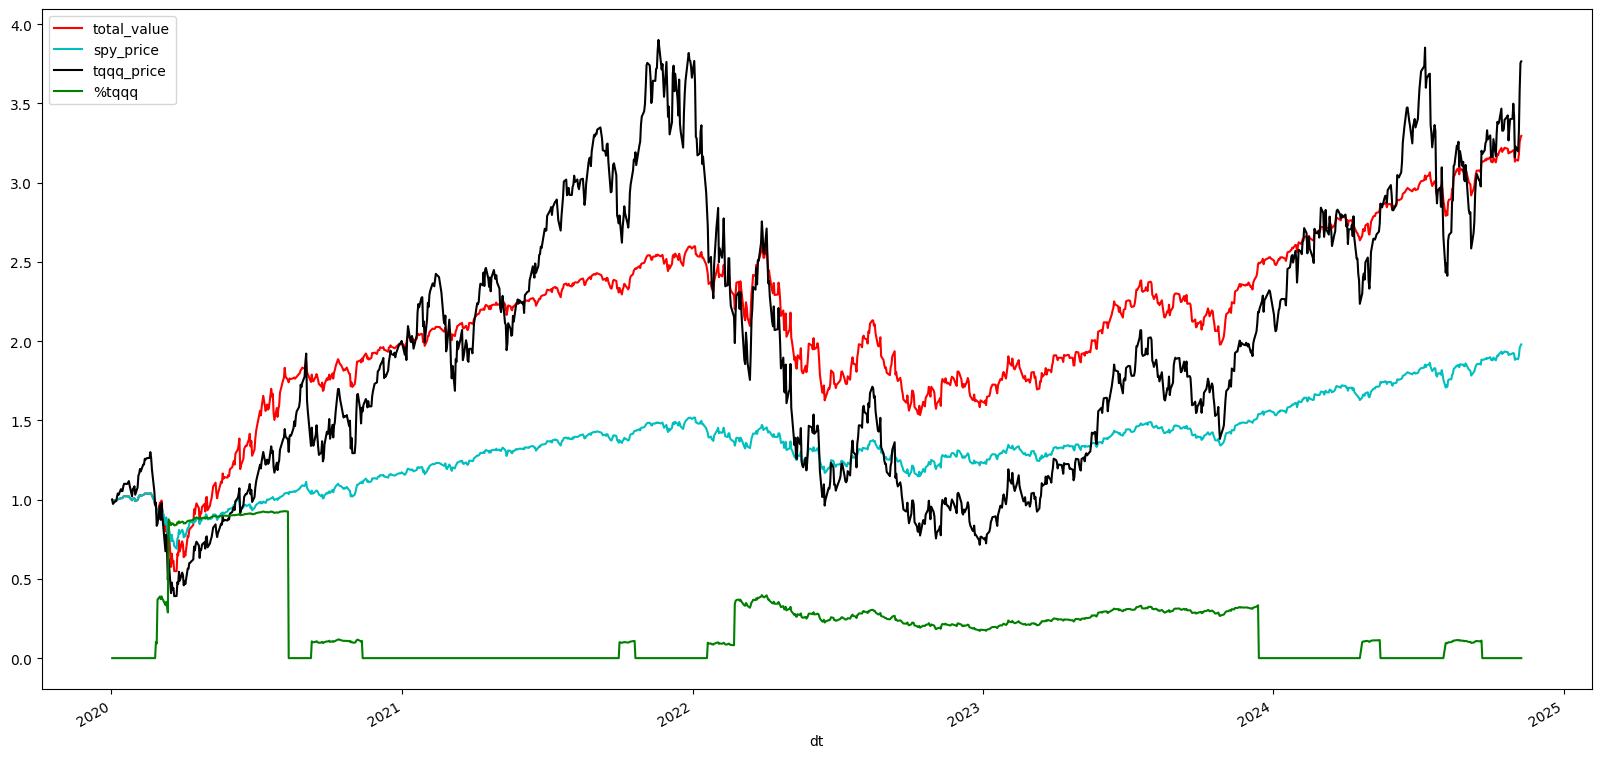

In [434]:
initial_investment = 1000
df1b, final, events = simulate_trading('2020-01-01', initial_investment=initial_investment, thresholds=[5, 10, 20])
df1['%tqqq'] = df1['tqqq_holding_value']*1.000/df1['total_value']
df1['%tqqq']



ax = (df1[['total_value']]/initial_investment).plot(figsize=(20,10),color = 'r')
(df1['spy_price']/(df1['spy_price'].iloc[0])).plot(ax = ax, color = 'c')
(df1['tqqq_price']/(df1['tqqq_price'].iloc[0])).plot(ax=ax, color = 'k')
df1['%tqqq'].plot(ax=ax, color ='green')
ax.legend()

[*********************100%***********************]  2 of 2 completed


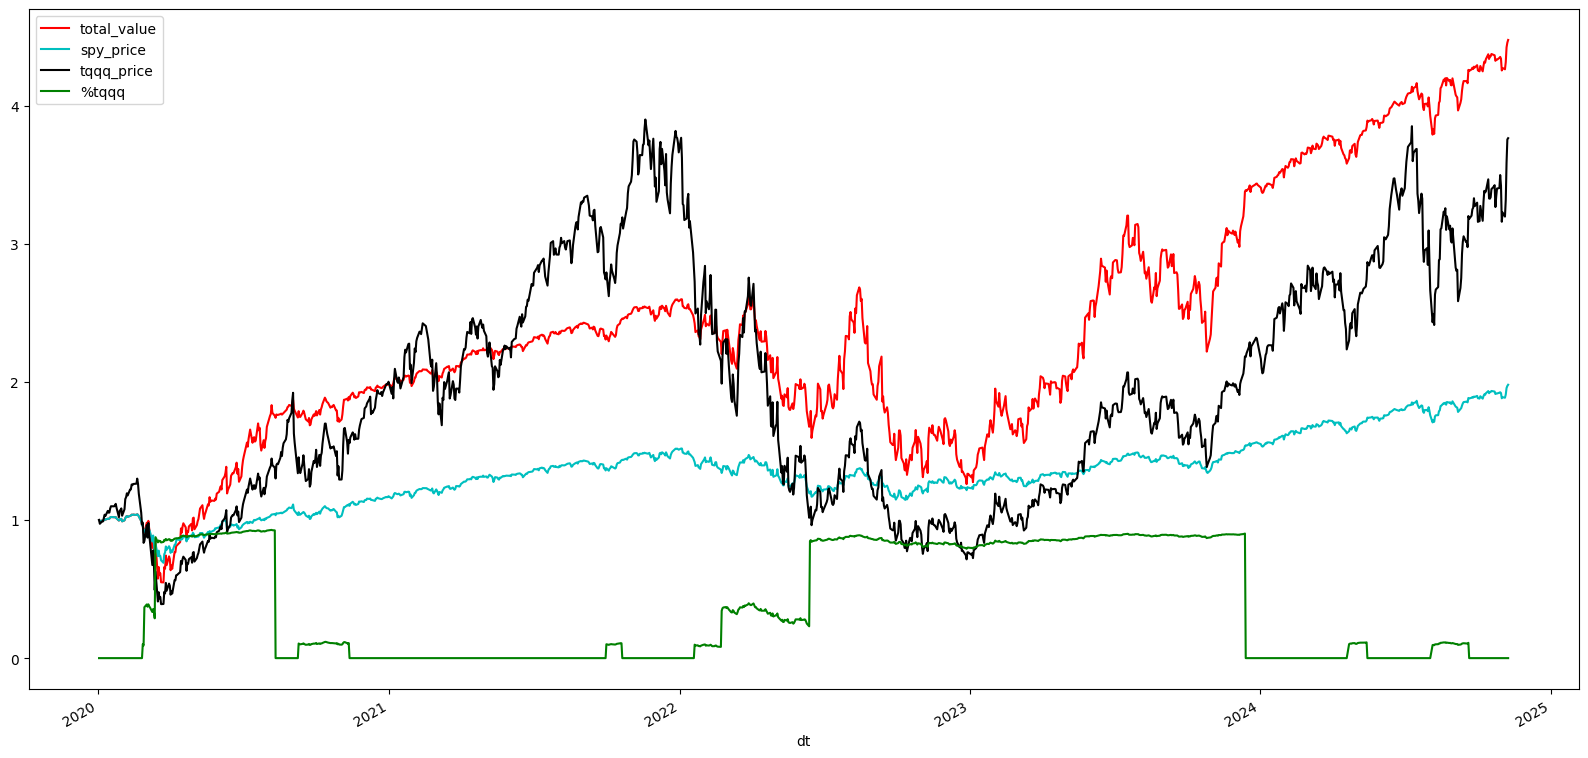

In [430]:
initial_investment = 1000
df1, final, events = simulate_trading('2020-01-01', initial_investment=initial_investment, thresholds=[5, 10, 25])
df1['%tqqq'] = df1['tqqq_holding_value']*1.000/df1['total_value']
df1['%tqqq']



ax = (df1[['total_value']]/initial_investment).plot(figsize=(20,10),color = 'r')
(df1['spy_price']/(df1['spy_price'].iloc[0])).plot(ax = ax, color = 'c')
(df1['tqqq_price']/(df1['tqqq_price'].iloc[0])).plot(ax=ax, color = 'k')
df1['%tqqq'].plot(ax=ax, color ='green')
ax.legend()

# for dt in (df1[df1.if_event]).index:
#     ax.axvline(x=dt, color='red', linestyle='--', lw=0.1, label=f'Trigger at {dt}')


# (df1[['spy_holding_value','tqqq_holding_value']]/initial_investment).plot(figsize=(20,10))


# ax = df1['spy_price'].plot(figsize=(20,10))
# df1['retracement'].plot(ax=ax.twinx(),color='r')

# ax2 = df1['tqqq_price'].plot(style ='.')
# df1['retracement_tqqq'].plot(ax=ax2.twinx(),color='r',style ='.')


[*********************100%***********************]  2 of 2 completed


<Axes: xlabel='dt'>

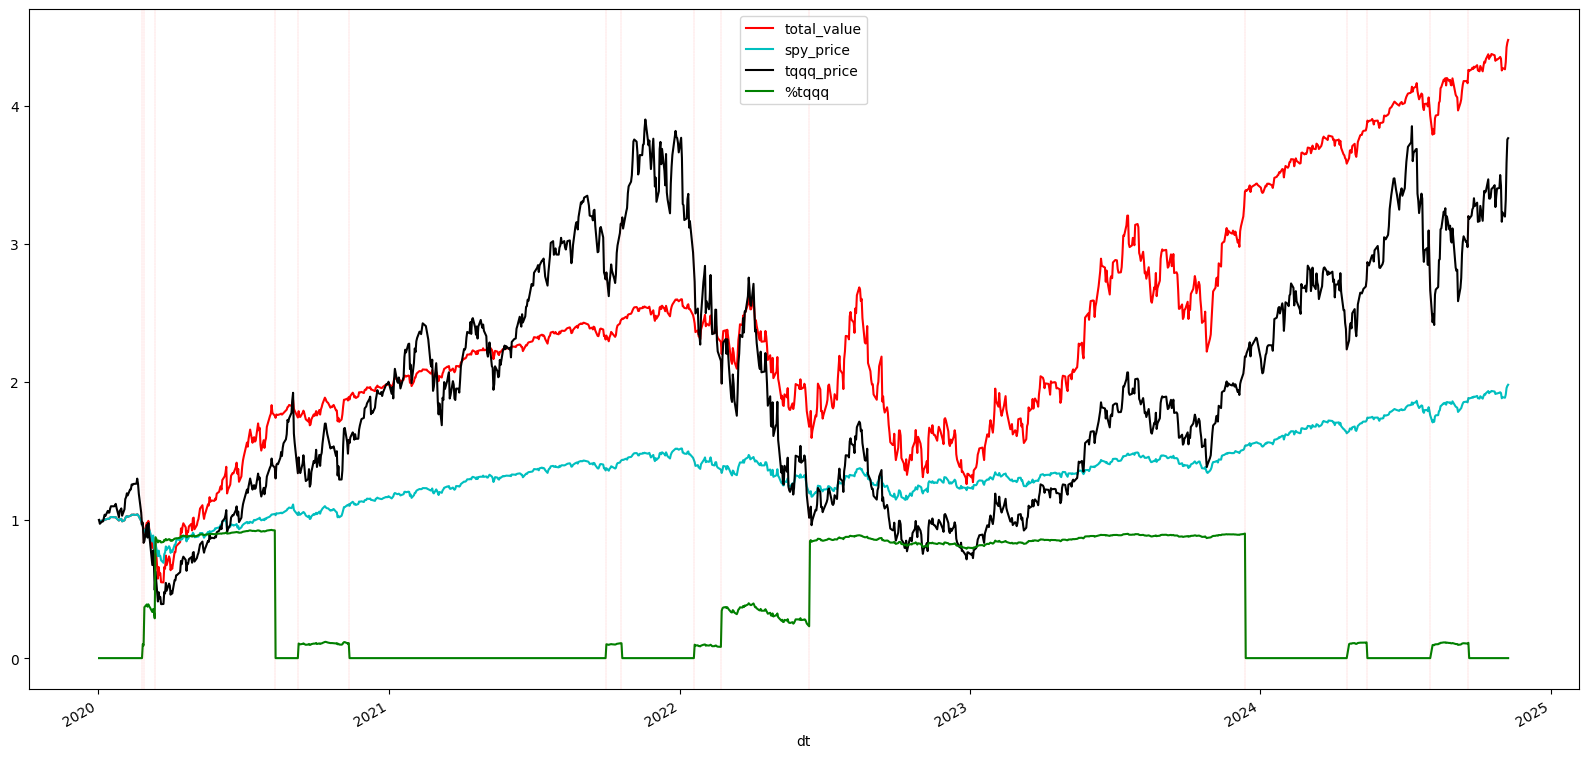

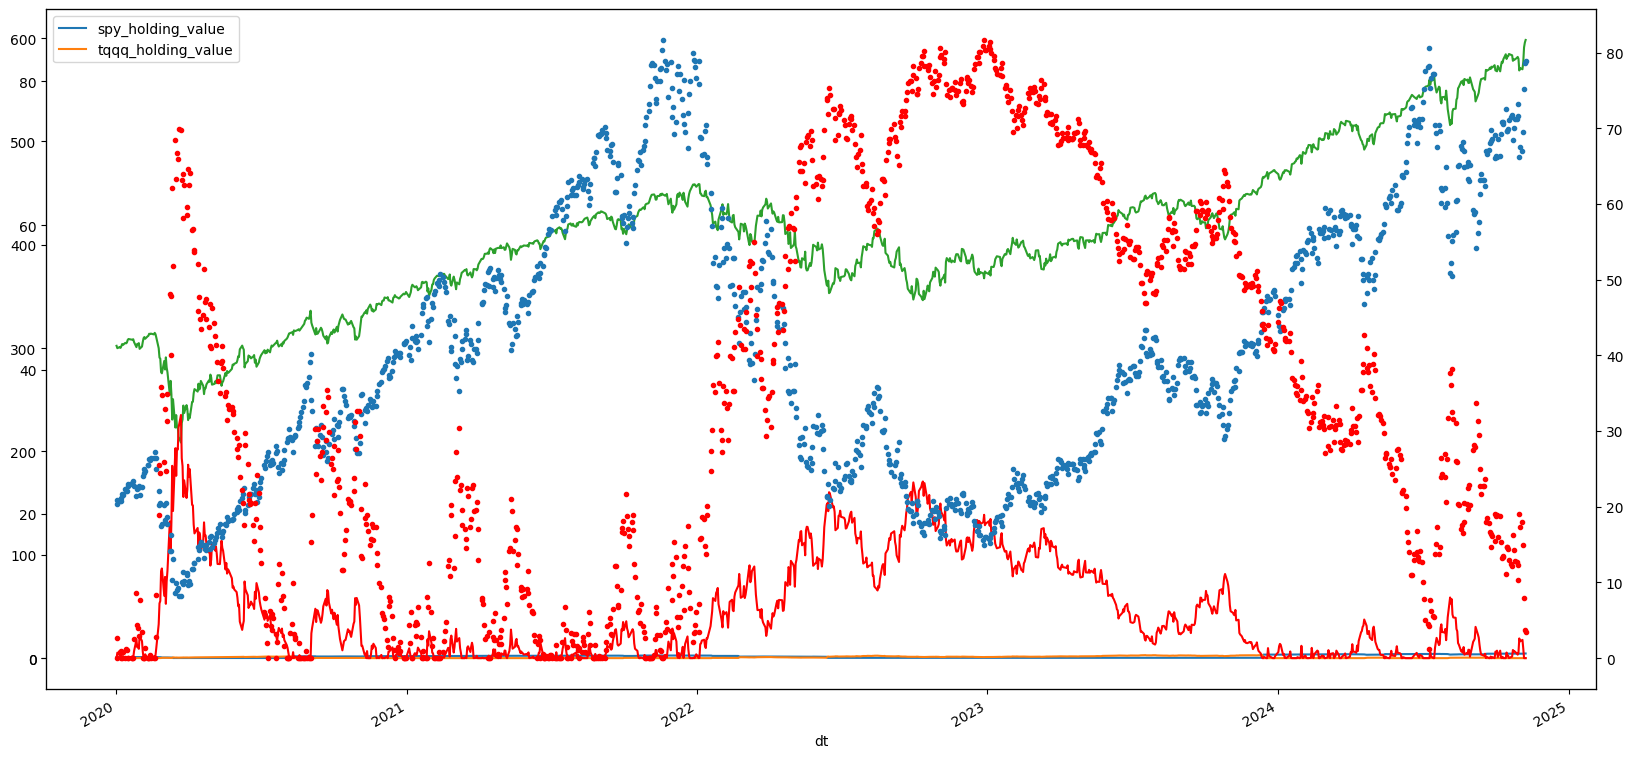

In [423]:
initial_investment = 1000
df1, final, events = simulate_trading('2020-01-01', initial_investment=initial_investment, thresholds=[5, 10, 20])
df1['%tqqq'] = df1['tqqq_holding_value']*1.000/df1['total_value']
df1['%tqqq']



ax = (df1[['total_value']]/initial_investment).plot(figsize=(20,10),color = 'r')
(df1['spy_price']/(df1['spy_price'].iloc[0])).plot(ax = ax, color = 'c')
(df1['tqqq_price']/(df1['tqqq_price'].iloc[0])).plot(ax=ax, color = 'k')
df1['%tqqq'].plot(ax=ax, color ='green')
ax.legend()

for dt in (df1[df1.if_event]).index:
    ax.axvline(x=dt, color='red', linestyle='--', lw=0.1, label=f'Trigger at {dt}')


(df1[['spy_holding_value','tqqq_holding_value']]/initial_investment).plot(figsize=(20,10))


ax = df1['spy_price'].plot(figsize=(20,10))
df1['retracement'].plot(ax=ax.twinx(),color='r')

ax2 = df1['tqqq_price'].plot(style ='.')
df1['retracement_tqqq'].plot(ax=ax2.twinx(),color='r',style ='.')


[*********************100%***********************]  2 of 2 completed


<Axes: xlabel='dt'>

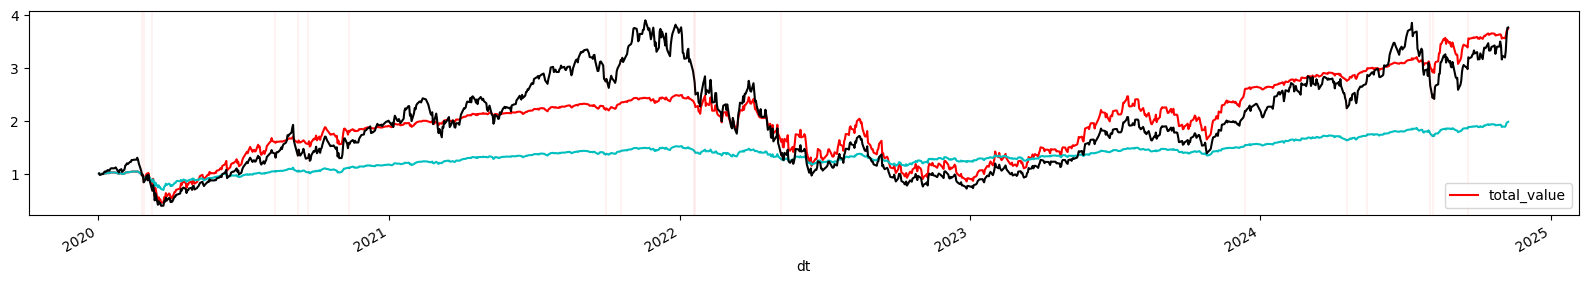

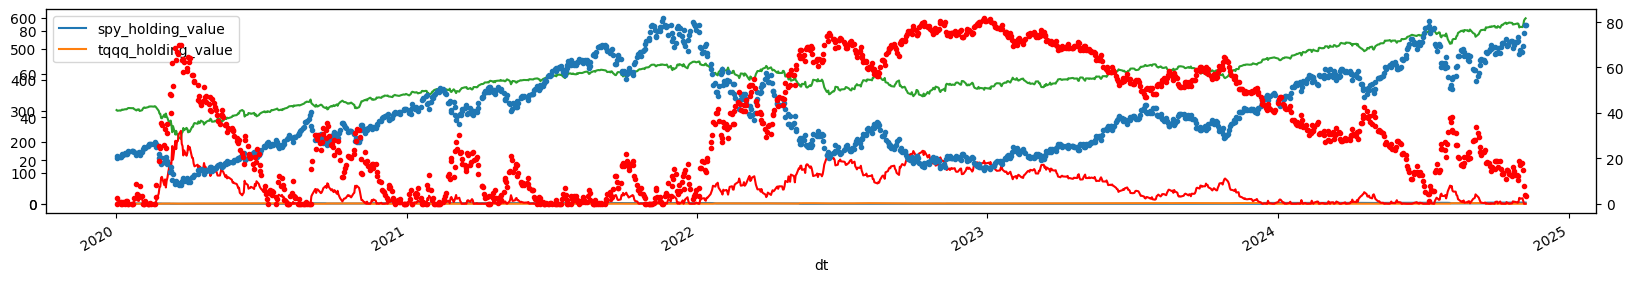

In [401]:
initial_investment = 1000
df1, final, events = simulate_trading('2020-01-01', initial_investment=initial_investment, thresholds=[5, 8, 15])
ax = (df1[['total_value']]/initial_investment).plot(figsize=(20,3),color = 'r')
(df1['spy_price']/(df1['spy_price'].iloc[0])).plot(ax = ax, color = 'c')
(df1['tqqq_price']/(df1['tqqq_price'].iloc[0])).plot(ax=ax, color = 'k')

for dt in (df1[df1.if_event]).index:
    ax.axvline(x=dt, color='red', linestyle='--', lw=0.1, label=f'Trigger at {dt}')


(df1[['spy_holding_value','tqqq_holding_value']]/initial_investment).plot(figsize=(20,3))


ax = df1['spy_price'].plot(figsize=(20,3))
df1['retracement'].plot(ax=ax.twinx(),color='r')

ax2 = df1['tqqq_price'].plot(style ='.')
df1['retracement_tqqq'].plot(ax=ax2.twinx(),color='r',style ='.')


In [268]:
import yfinance as yf
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed

HOOD


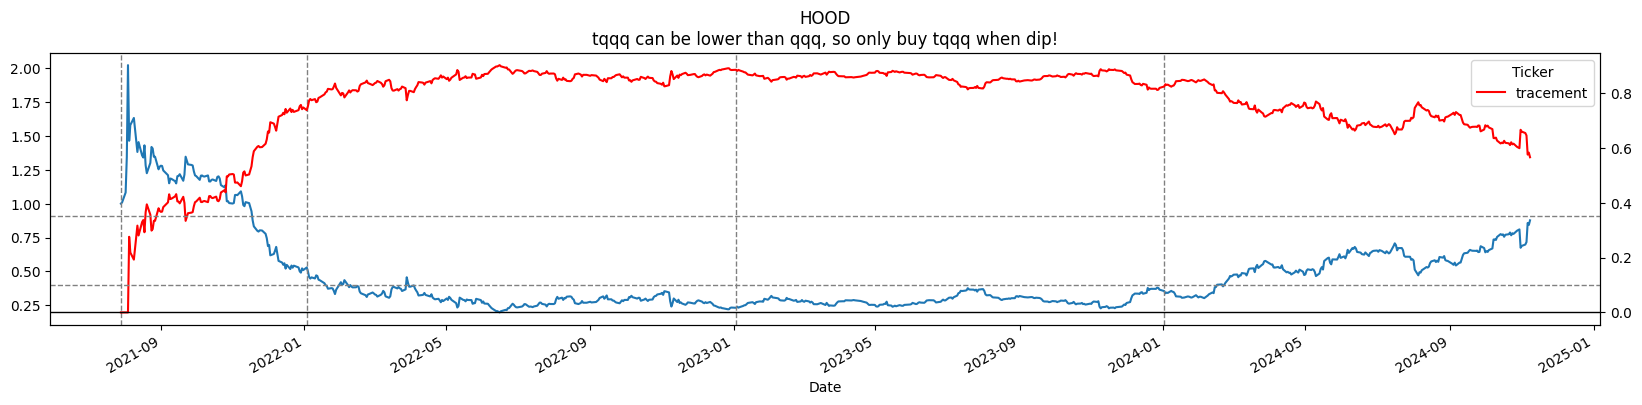

[*********************100%***********************]  1 of 1 completed

TQQQ


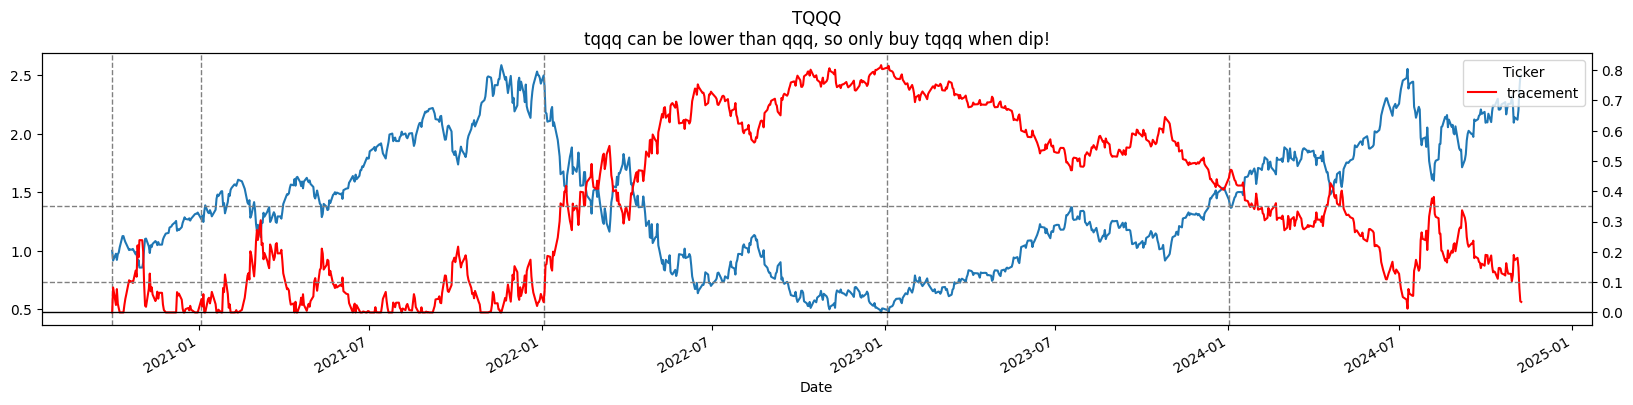

[*********************100%***********************]  1 of 1 completed

SPY


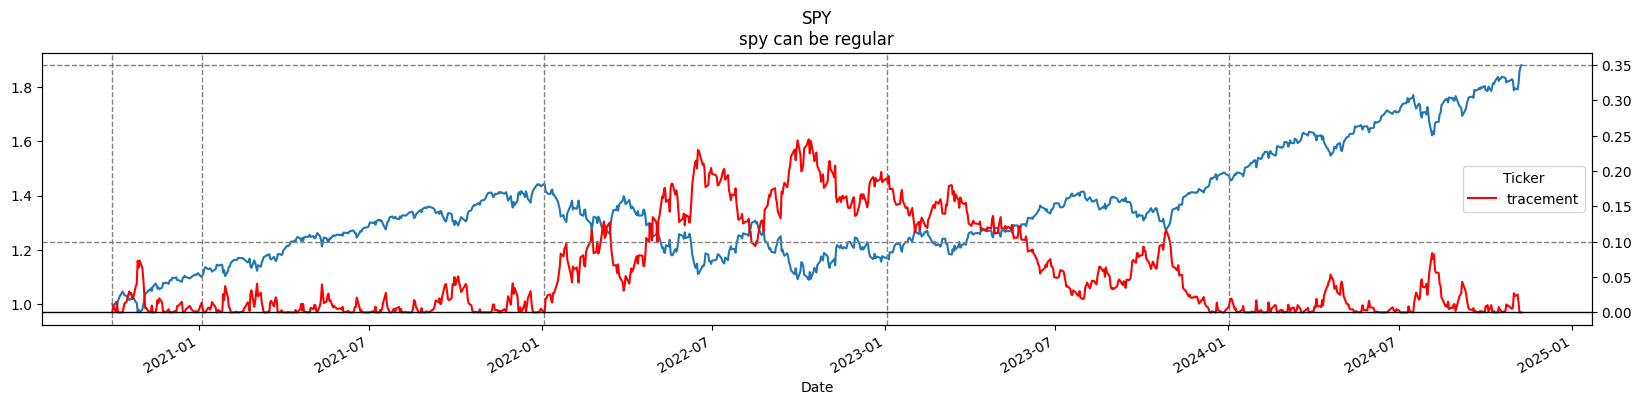

[*********************100%***********************]  1 of 1 completed

QQQ


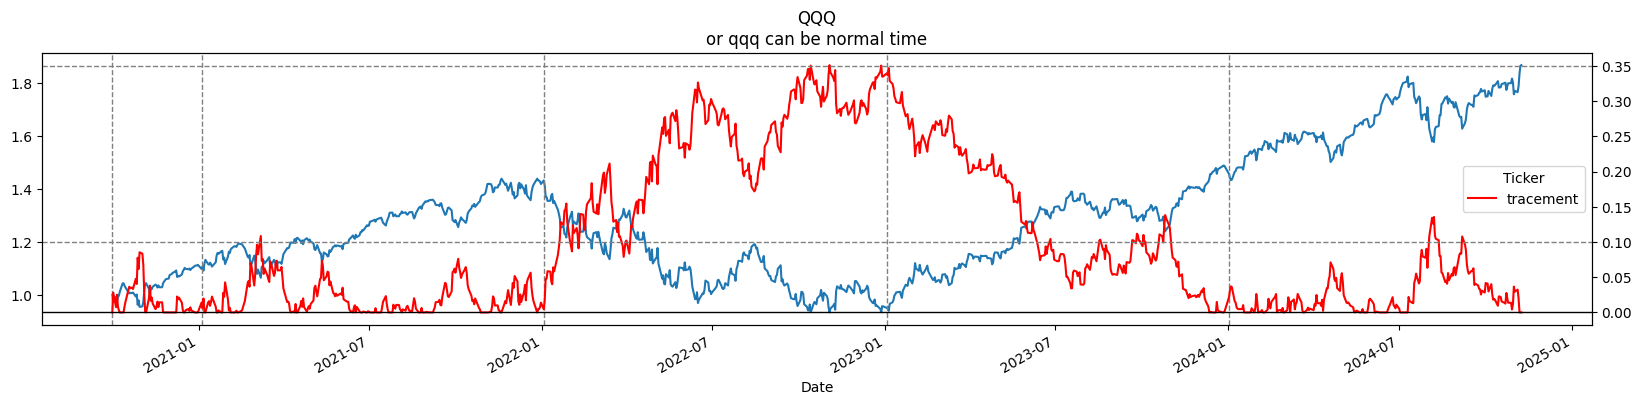

[*********************100%***********************]  1 of 1 completed

IWM


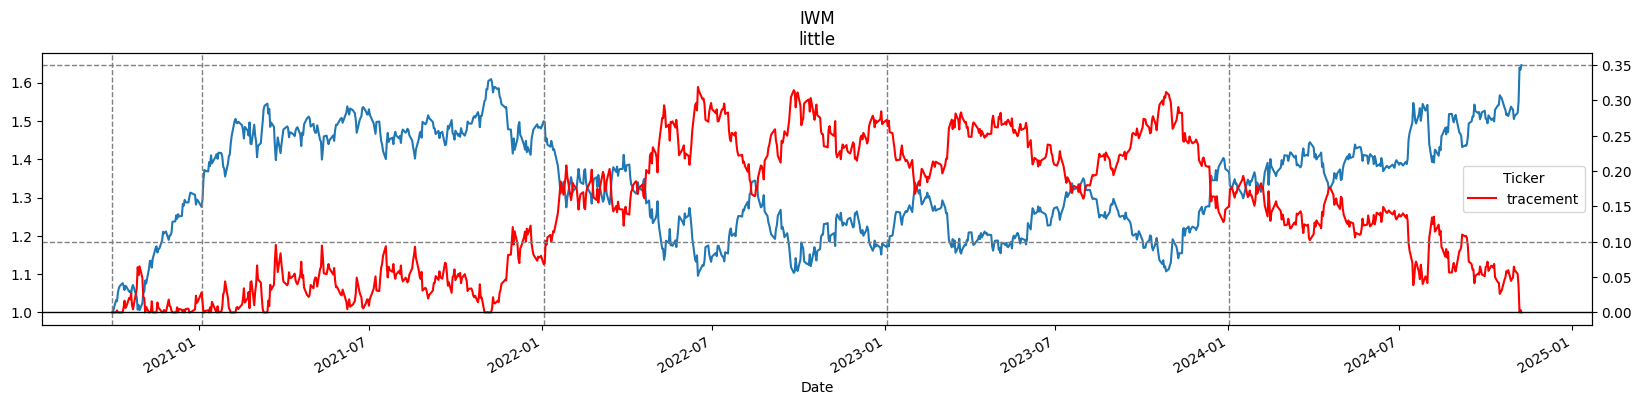

In [269]:
def get_stock(stock_sym,title):    
    print(stock_sym)
    df = yf.download(stock_sym, start='2020-10-01')
    
    close_price_df = df['Adj Close'].copy()
    daily_price = list(close_price_df[stock_sym])
    
    first_day = daily_price[0]
    
    close_price_df['pct_price_incr'] = close_price_df[stock_sym]/first_day
    
    close_price_df['yr'] = close_price_df.index.year
    
    max_price_in_history = [daily_price[0]]
    
    for i in range(len(daily_price)-1):
        i = i+1
        max_price_in_history.append(max(max_price_in_history[-1],daily_price[i]))
    
    close_price_df['max_so_far'] = max_price_in_history
    close_price_df['tracement'] = 1-close_price_df[stock_sym]/close_price_df['max_so_far']
    ax = close_price_df['pct_price_incr'].plot(figsize=(20,4),
                                        title=f'{stock_sym}\n{title}')
    ax2 = ax.twinx()
    close_price_df[['tracement']].plot(ax=ax2, color = ('r','g'))
    for year in close_price_df['yr'].unique():
        year_start = close_price_df[close_price_df['yr'] == year].index[0]  # Get the first date of each year
        ax.axvline(x=year_start, color='gray', linestyle='--', lw=1)  # Add a vertical line
    
    
    
    ax2.axhline(y=0.35, color='gray', linestyle='--', lw=1)  # Add a vertical line
    ax2.axhline(y=0.1, color='gray', linestyle='--', lw=1)  # Add a vertical line
    ax2.axhline(y=0, color='black', linestyle='-', lw=1)  # Add a vertical line
    plt.show()
    return close_price_df

close_price_df = get_stock('HOOD','tqqq can be lower than qqq, so only buy tqqq when dip!')
close_price_df = get_stock('TQQQ','tqqq can be lower than qqq, so only buy tqqq when dip!')
close_price_df = get_stock('SPY', 'spy can be regular')
close_price_df = get_stock('QQQ', 'or qqq can be normal time')
close_price_df = get_stock('IWM', 'little')


In [104]:
close_price_df[stock_sym]/first_day



NameError: name 'stock_sym' is not defined

In [29]:
# 每年都会一定有20%的回撤， 然后50%的也大概率

<Axes: title={'center': 'always has day at 40% or more global tracement per year-> should we buy. I think yes'}, xlabel='yr'>

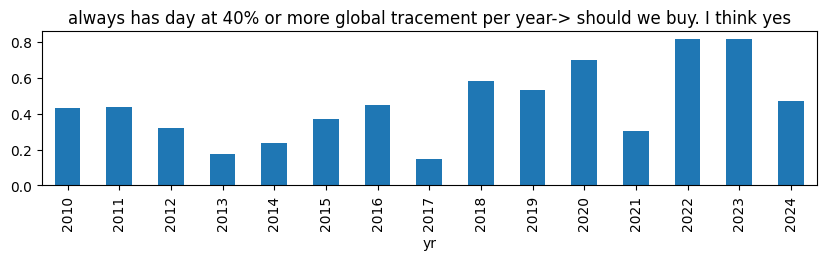

In [38]:
close_price_df.groupby('yr')['tracement'].max().plot(kind='bar',figsize=(10,2),
                                                    title= 'always has day at 40% or more global tracement per year-> should we buy. I think yes')

In [41]:
# 每年买一次好了。 就在40%的回撤就好。然后80%的回撤也买一回？这是历史最多的了

In [45]:
那赚多少呢？global回撤是0 就表示创新高了。 每年多少次创新高呢？->每年都会！吗？

SyntaxError: invalid character '？' (U+FF1F) (1323134918.py, line 1)

In [ ]:
# 如果每年在 40% global tracement买， 年底回报是多少， 1年回报是多少

In [ ]:
close_price_df.groupby('yr')['tracement']

In [ ]:
close_price_df.

<Axes: title={'center': 'always reaching new high every year as well(need to check the high post the  tracement date)'}, xlabel='yr'>

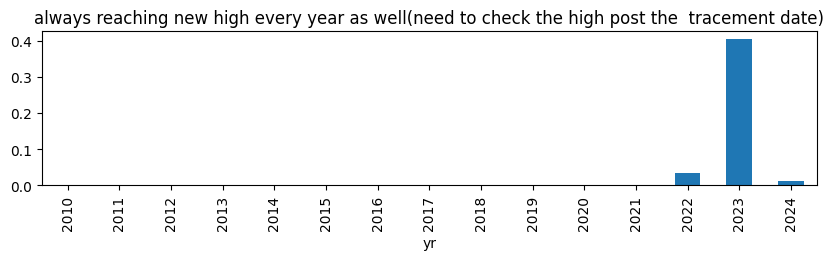

In [47]:
close_price_df.groupby('yr')['tracement'].min().plot(
    kind='bar',figsize=(10,2),
    title= 'always reaching new high every year as well(need to check the high post the  tracement date)')

In [55]:
import pandas as pd

# Assuming close_price_df is the DataFrame you mentioned.
# close_price_df = ...
def add_return_columns(df):
    # Convert dt to datetime if it's not already
    df.index = pd.to_datetime(df.index)
    
    # Initialize empty columns for the returns
    df['pct_return_until_eoy'] = None
    df['pct_return_after_365_days'] = None
    
    # Iterate over each row in the DataFrame
    for i, row in df.iterrows():
        # For pct_return_until_eoy, find the last row of the same year
        same_year_df = df[df.index.year == row.name.year]
        last_of_year = same_year_df.tail(1)  # Get the last row of the year
        
        if not last_of_year.empty:
            price_at_eoy = last_of_year['TQQQ'].iloc[0]
            pct_return_eoy = (price_at_eoy - row['TQQQ']) / row['TQQQ'] * 100
            df.at[i, 'pct_return_until_eoy'] = pct_return_eoy
        
        # For pct_return_after_365_days, find the price 365 rows later
        future_idx = df.index.get_loc(i) + 365
        if future_idx < len(df):
            price_after_365 = df.iloc[future_idx]['TQQQ']
            pct_return_365 = (price_after_365 - row['TQQQ']) / row['TQQQ'] * 100
            df.at[i, 'pct_return_after_365_days'] = pct_return_365

    return df

# Apply the function to add the columns to the DataFrame
close_price_df = add_return_columns(close_price_df)


In [56]:
close_price_df[close_price_df.tracement>=0.4].groupby('yr').size()

yr
2010      5
2011      5
2016      6
2018     15
2019     16
2020     43
2022    206
2023    250
2024     15
dtype: int64

In [59]:
close_price_df[close_price_df.tracement>=0.4].groupby('yr')[['pct_return_until_eoy','pct_return_after_365_days']].mean()

Ticker,pct_return_until_eoy,pct_return_after_365_days
yr,,
2010,100.321583,101.808122
2011,25.444772,110.228157
2016,75.876909,211.555418
2018,-2.779921,121.960287
2019,112.764239,143.187126
2020,244.18408,427.865957
2022,-35.425376,100.890177
2023,61.015675,195.465861
2024,70.036055,NaN


In [58]:
close_price_df[close_price_df.tracement>=0.4].groupby('yr')[['pct_return_until_eoy','pct_return_after_365_days']].min()

Ticker,pct_return_until_eoy,pct_return_after_365_days
yr,,
2010,93.661764,84.628209
2011,21.562663,102.217116
2016,69.843819,198.518225
2018,-14.558777,63.521508
2019,100.398019,109.951038
2020,156.924817,257.316883
2022,-67.058559,-30.044486
2023,-1.629804,123.606564
2024,61.49997,NaN


In [65]:
def calculate_pct_return_per_year(df):
    # Initialize the 'pct_return_per_year' column
    df['pct_return_per_year'] = None

    # Iterate over each unique year in the 'yr' column
    for year in df['yr'].unique():
        # Filter the rows for the current year
        year_df = df[df['yr'] == year]

        # Get the first and last prices for that year
        first_price = year_df['TQQQ'].iloc[0]  # First available price in the year
        last_price = year_df['TQQQ'].iloc[-1]  # Last available price in the year

        # Calculate the percentage return for the year
        pct_return_year = (last_price - first_price) / first_price * 100

        # Assign the percentage return to the entire year
        df.loc[df['yr'] == year, 'pct_return_per_year'] = pct_return_year

    return df
close_price_df = calculate_pct_return_per_year(close_price_df)

close_price_df[close_price_df.tracement>=0.4].groupby('yr')[['pct_return_until_eoy','pct_return_after_365_days','pct_return_per_year']].min()

Ticker,pct_return_until_eoy,pct_return_after_365_days,pct_return_per_year
yr,,,
2010,93.661764,84.628209,78.061405
2011,21.562663,102.217116,-12.021247
2016,69.843819,198.518225,18.629369
2018,-14.558777,63.521508,-23.703979
2019,100.398019,109.951038,130.53508
2020,156.924817,257.316883,100.132127
2022,-67.058559,-30.044486,-79.676524
2023,-1.629804,123.606564,204.922626
2024,61.49997,NaN,73.768271


In [ ]:
# 显然比每天都投要好很多很多！

In [66]:
close_price_df.groupby('yr')[['pct_return_until_eoy','pct_return_after_365_days','pct_return_per_year']].min()

Ticker,pct_return_until_eoy,pct_return_after_365_days,pct_return_per_year
yr,,,
2010,-2.215151,-14.629963,78.061405
2011,-27.182189,1.5788,-12.021247
2012,-20.500613,34.154683,44.085695
2013,0.0,76.162478,119.275545
2014,-7.509466,-19.96489,60.849384
2015,-10.337525,-8.527723,18.201145
2016,-5.629723,87.769319,18.629369
2017,-5.549139,-13.278799,112.907672
2018,-48.841322,-47.830808,-23.703979


In [ ]:
# 下面就是看看到底应该 什么时候卖呢。 或者说如何保证仓位不会太大 呢？

In [67]:
# 一个基本想法是， 赚钱了就把钱取出来其实。 所以控制仓位永远是30万以下。 
# 另一个想法是。 每年到底投资多少。 其实每年大跌了以后，可以考略： 
 * 40% 买 30万
 * 如果40%基础上又跌40%， 就是60% retention， 就是36% retention的守候， 再买30万， 
一共两次 应该够了
至于说， 何时卖。 这个问题其实是：
* 我懂了！！！！ 在不同的global回撤应该保持的总价值数。
* 比如10% global应该是10万。 20% 应该是20万。 这样从20%涨回10%回撤，我们赚钱了以后应该保证还是持有10万仓位这样的逻辑！

In [ ]:
从90%涨到100%， 涨了1。1所以正好多了1万。 不对



In [ ]:
# 为了降低风险 比如 我们只赚回撤反弹的钱。 左侧买入相当于。